# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

/tmp/ipykernel_891/3379868149.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tablas = pd.read_html(response.text)
/tmp/ipykernel_891/3379868149.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Streams', y='Song', data=top_canciones, palette='viridis')


Datos insertados correctamente en SQLite.


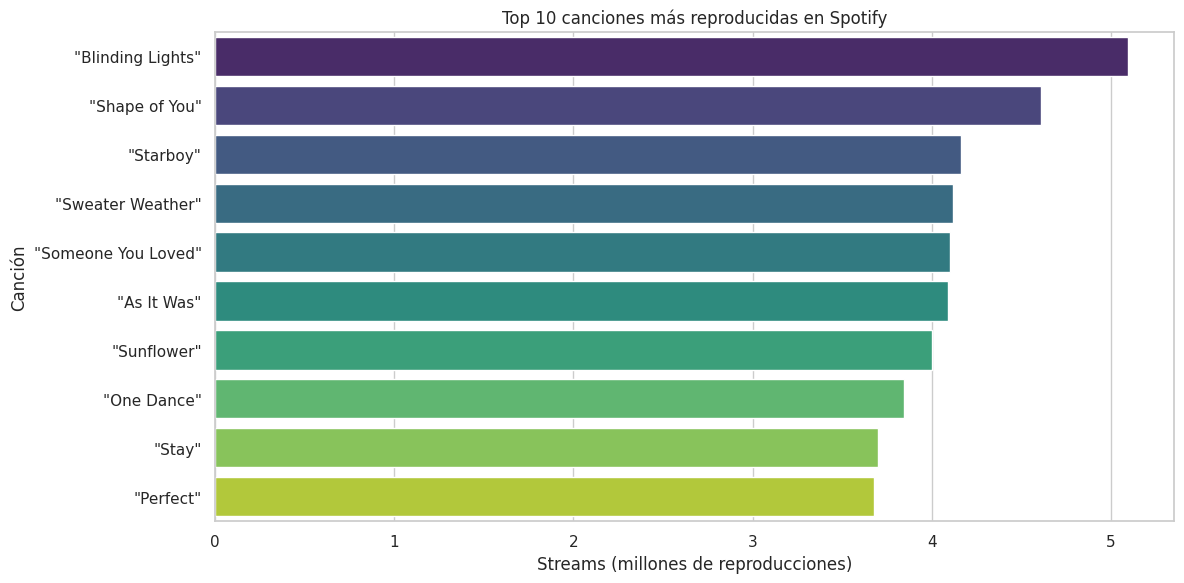

/tmp/ipykernel_891/3379868149.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_artistas.values, y=top_artistas.index, palette='magma')


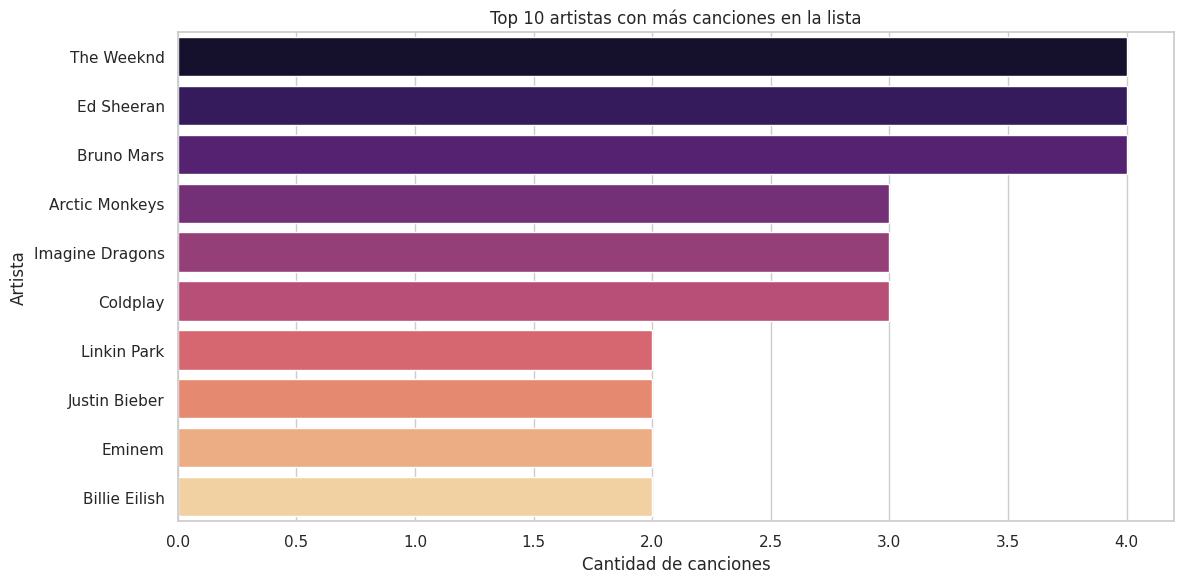

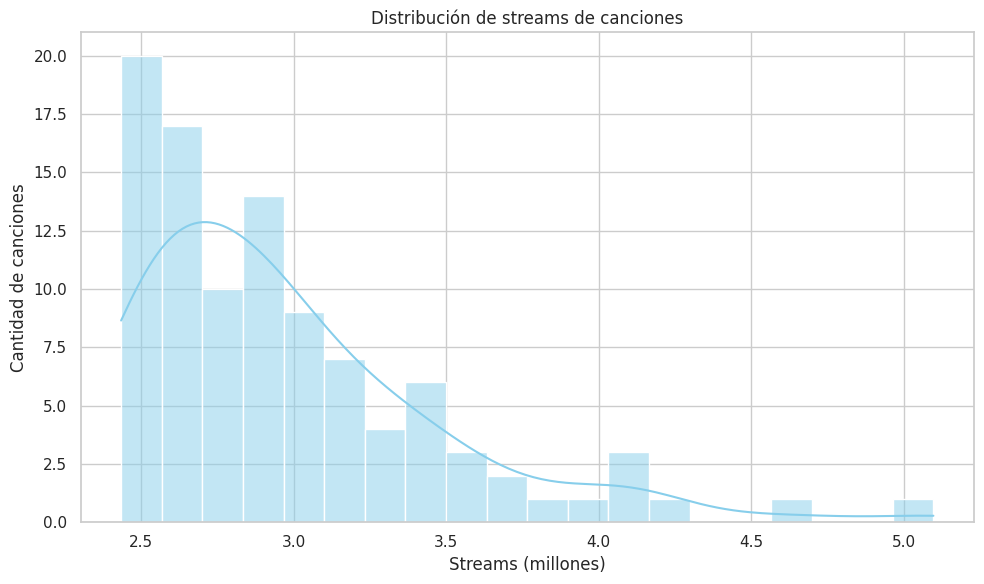

In [11]:
import requests
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


#Descargo HTML
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)
response.raise_for_status()

tablas = pd.read_html(response.text)
df_spotify = tablas[0]

#Ordeno y limpio columnas
df_spotify.columns = [c.strip().replace('\n', ' ').replace('[1]', '').replace('[2]', '') for c in df_spotify.columns]

rename_dict = {}
for col in df_spotify.columns:
    if 'Title' in col or 'Song' in col:
        rename_dict[col] = 'Song'
    elif 'Artist' in col:
        rename_dict[col] = 'Artist'
    elif 'Streams' in col:
        rename_dict[col] = 'Streams'
    elif 'Year' in col:
        rename_dict[col] = 'Release_Year'

df_spotify.rename(columns=rename_dict, inplace=True)

#Limpio datos de streams

df_spotify['Streams'] = df_spotify['Streams'].astype(str).str.replace(',', '').str.replace('B', '')

df_spotify['Streams'] = pd.to_numeric(df_spotify['Streams'], errors='coerce')

df_spotify.dropna(subset=['Streams', 'Song', 'Artist'], inplace=True)
df_spotify['Song'] = df_spotify['Song'].str.strip()
df_spotify['Artist'] = df_spotify['Artist'].str.strip()

#SQLITE
conexion = sqlite3.connect("spotify_records.db")
cursor = conexion.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS spotify_records (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    rank INTEGER,
    song TEXT,
    artist TEXT,
    streams REAL,
    release_year INTEGER
)
""")

#Limpio tabla antes de insertar
cursor.execute("DELETE FROM spotify_records")

#Inserto datos
for i, row in df_spotify.iterrows():
    rank = row.name + 1  # Usamos el índice como ranking
    release_year = row.get('Release_Year', None)
    cursor.execute("""
        INSERT INTO spotify_records (rank, song, artist, streams, release_year)
        VALUES (?, ?, ?, ?, ?)
    """, (rank, row['Song'], row['Artist'], row['Streams'], release_year))

conexion.commit()
conexion.close()

print("Datos insertados correctamente en SQLite.")

#Tablas he probado colores y demás que vi investigando
sns.set_style("whitegrid")

#10 canciones más reproducidas
top_canciones = df_spotify.sort_values(by='Streams', ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x='Streams', y='Song', data=top_canciones, palette='viridis')
plt.title("Top 10 canciones más reproducidas en Spotify")
plt.xlabel("Streams (millones de reproducciones)")
plt.ylabel("Canción")
plt.tight_layout()
plt.show()

#10 artistas con más canciones en la lista
top_artistas = df_spotify['Artist'].value_counts().head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_artistas.values, y=top_artistas.index, palette='magma')
plt.title("Top 10 artistas con más canciones en la lista")
plt.xlabel("Cantidad de canciones")
plt.ylabel("Artista")
plt.tight_layout()
plt.show()

#Distribución de streams de todas las canciones
plt.figure(figsize=(10,6))
sns.histplot(df_spotify['Streams'], bins=20, kde=True, color='skyblue')
plt.title("Distribución de streams de canciones")
plt.xlabel("Streams (millones)")
plt.ylabel("Cantidad de canciones")
plt.tight_layout()
plt.show()
